In [1]:
import os
import re
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.widgets as widgets
import scipy.io as sio
import SimpleITK as sitk
from glob import glob
from zipfile import ZipFile

from scipy.signal import butter, filtfilt, welch, find_peaks
from scipy.ndimage.filters import gaussian_filter1d

In [2]:
%matplotlib notebook

## Step 1: Load images and save a color volume

In [3]:
histology_loc = r"T:\zap-n-zip\EEG_exp\mouse599017\histology"

resampled_zip = glob(histology_loc + '/**/resampled_images.zip', recursive=True)[0]
with ZipFile(resampled_zip, 'r') as zipObj:
    zipObj.extractall(path=histology_loc)

In [4]:
intensity_arrays = {}
for imcolor in ['red', 'green', 'blue']:
    resamp_image = sitk.ReadImage(os.path.join(histology_loc, 'resampled_' + imcolor + '.mhd'))
    intensity_arrays[imcolor] = sitk.GetArrayFromImage(resamp_image).T

Plot intensity values

<IPython.core.display.Javascript object>


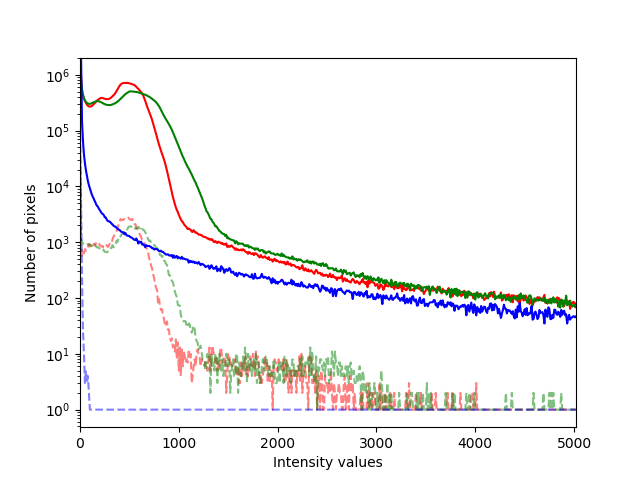

Text(0, 0.5, 'Number of pixels')

In [34]:
exampleslice = 275
inbins = np.arange(0, 40000, 10)
fig, ax = plt.subplots()
for colori, carray in intensity_arrays.items():
    slicepixs, binins = np.histogram(carray[exampleslice,:,:], bins=inbins)
    allpixs, binins = np.histogram(carray, bins=inbins)
    ax.semilogy(inbins[:-1], slicepixs+1, color=colori, linestyle='dashed', alpha=0.5)
    ax.semilogy(inbins[:-1], allpixs+1, color=colori)
ax.set_xlim([0, 40000])
ax.set_xlabel('Intensity values')
ax.set_ylabel('Number of pixels')

Map intensity values to 0-255 uint8

In [35]:
levels ={ 
    'red': [250, 2800],
    'green': [400, 3200], # green
    'blue': [0, 1000], # blue
}

level_adjusted_arrays = []
for colori in levels.keys():
    print(colori)
    colarray = np.clip(intensity_arrays[colori], a_min=levels[colori][0], a_max=levels[colori][1])
    colarray = colarray - levels[colori][0]
    colarray = (colarray * 255. / (levels[colori][1] - levels[colori][0])).astype('uint8')
    level_adjusted_arrays.append(colarray)
color_volume = np.stack(level_adjusted_arrays, axis=-1)
print(color_volume.shape)

red
green
blue
(528, 320, 456, 3)


Check the levels

<IPython.core.display.Javascript object>


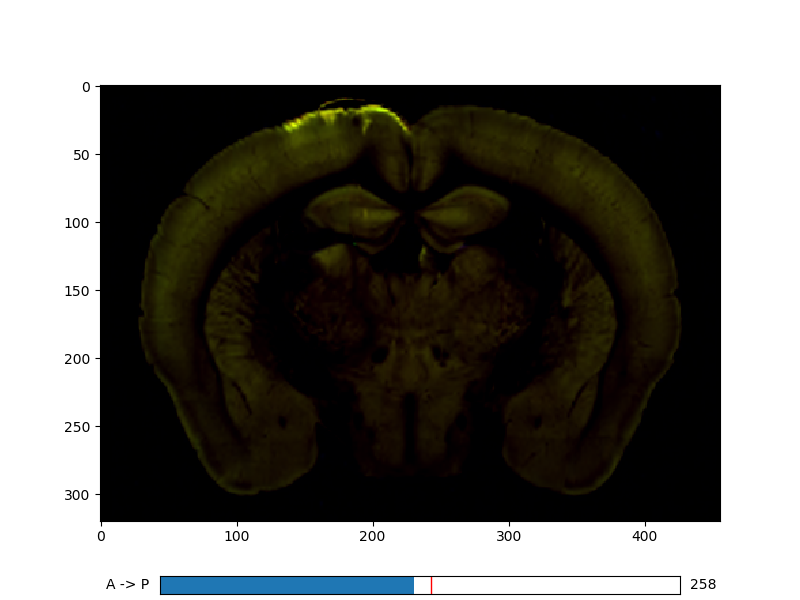

In [36]:
APslice = 275
fig, ax = plt.subplots(figsize=(8,6))
img = ax.imshow(color_volume[APslice,:,:,:], interpolation='none')#, vmin=0, vmax=100)

ax_slider = plt.axes([0.20, 0.01, 0.65, 0.03])#, facecolor=axcolor)
slider = widgets.Slider(ax_slider, 'A -> P', 0, color_volume.shape[0], valinit=APslice, valfmt='%.0f')

def update(val):
    newAP = int(np.round(slider.val))
    ax.imshow(color_volume[newAP,:,:,:], interpolation='none')
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()

Looks good? Save it

## Step 2: volume_registration.py step fits a line to annotated points and finds CCF coords for points along probe

Make output file name

In [27]:
histology_loc = r"T:\zap-n-zip\EEG_exp\mouse586468\histology"
probe_annotations = pd.read_csv(os.path.join(histology_loc, 'probe_annotations.csv'), index_col = 0)
probe_annotations.head()

,AP,ML,DV,probe_name
0,187,227,134,Probe F1
1,187,222,128,Probe F1
2,188,227,133,Probe F1
3,189,230,138,Probe F1
4,190,230,136,Probe F1


In [89]:
labels = np.load(
    '//allen/programs/braintv/workgroups/tiny-blue-dot/zap-n-zip/TC_CCF_template_files/annotation_volume_25um_by_index.npy'
)
volume_template = np.load(
    '//allen/programs/braintv/workgroups/tiny-blue-dot/zap-n-zip/TC_CCF_template_files/template_volume_25um.npy'
)
## orientation is: AP, DV, ML ##
structure_tree = pd.read_csv(
    '//allen/programs/braintv/workgroups/tiny-blue-dot/zap-n-zip/TC_CCF_template_files/structure_tree_safe_2017.csv'
)

In [92]:
print(labels.shape)
print(volume_template.shape)
print('Hemisphere mid line: {:d}'.format(int(volume_template.shape[2]/2)))

(528, 320, 456)
(528, 320, 456)
Hemisphere mid line: 228


### Make initial_ccf_coordinates.csv file that is used by the refinement_app.py in the OPT process

#### Run for all probes and save "initial_ccf_coordinates.csv"

In [5]:
probes = ('Probe A1', 'Probe B1', 'Probe C1', 'Probe D1', 'Probe E1', 'Probe F1',
          'Probe A2', 'Probe B2', 'Probe C2', 'Probe D2', 'Probe E2', 'Probe F2')
colors = ('red', 'orange', 'brown', 'green', 'blue', 'purple',
          'red', 'orange', 'brown', 'green', 'blue', 'purple')

In [6]:
df_columns = ['probe','structure_id', 'A/P','D/V','M/L']
df = pd.DataFrame(columns = df_columns)

In [8]:
for probe_idx, probe in enumerate(probes):
    x = probe_annotations[probe_annotations.probe_name == probe].ML
    y = probe_annotations[probe_annotations.probe_name == probe].DV
    z = probe_annotations[probe_annotations.probe_name == probe].AP

    if len(z) > 0:
        print(probe)
        data = np.vstack((z,y,x)).T ## this is now ordered AP, DV, ML
        datamean = data.mean(axis=0)
        D = data - datamean
        m1 = np.min(D[:,1]) * 2
        m2 = np.max(D[:,1]) * 2
        uu,dd,vv = np.linalg.svd(D)
        linepts = vv[0] * np.mgrid[-200:200:0.7][:,np.newaxis]
        linepts += datamean
        
        if linepts[-1,1] - linepts[0,1] < 0:
            linepts = np.flipud(linepts)
        
        structure_ids = np.zeros((linepts.shape[0],))
        ccf_coordinates = np.zeros((linepts.shape[0],3))
        for j in range(linepts.shape[0]):
            ccf_coordinate = np.around(linepts[j,:]).astype('int')
            ccf_coordinates[j,:] = ccf_coordinate
            
            if ccf_coordinate[1] < 0: # if D/V is neg, set structure_ids to -1
                structure_ids[j] = 0
            else:
                try:
                    structure_ids[j] = labels[ccf_coordinate[0], ccf_coordinate[1], ccf_coordinate[2]]
                except IndexError:
                    structure_ids[j] = -1

        data = {
            'probe': [probe]*linepts.shape[0],
            'structure_id': structure_ids.astype('int'),
            'A/P' : ccf_coordinates[:,0].astype('int'),
            'D/V' : ccf_coordinates[:,1].astype('int'),
            'M/L' : ccf_coordinates[:,2].astype('int')
        }
        
        probe_df = pd.DataFrame(data)
        df = pd.concat((df, probe_df), ignore_index=True)

Probe A1
Probe B1
Probe F1


At this point, the dataframe has entries for all experiments that were annotated, labeled "Probe A1". The capitals and spaces confuse the refinement step, so let's split the experiments and correct the probe names.

In [9]:
exp_days = np.unique([x[-1] for x in df.probe.unique()]) # this will be 1 and/or 2 if there are multiple experiments annotated
for daynum in exp_days:
    mask = df['probe'].str.contains(daynum)
    split_df = df[mask].reset_index(drop=True)
    ## correct the probe name (removes capitals, space, and number) ##
    split_df['probe'] = split_df['probe'].apply(lambda x: x[0].lower() + x[1:-3] + x[-2])
    ## save each experiment as a separate file ##
    output_file = os.path.join(histology_loc, 'initial_ccf_coordinates_exp{}.csv'.format(daynum))
    print('Saving initial coordinates for experiment {} here: {}'.format(daynum, output_file))
    split_df.to_csv(output_file, index=False) # , index=False to avoid saving the indices

Saving initial coordinates for experiment 1 here: T:\zap-n-zip\EEG_exp\mouse590479\histology\initial_ccf_coordinates_exp1.csv


#### Testing on one probe to see how it works

In [67]:
probe = 'Probe F2'
surface_ch = 360
# air_ch = 320

## get coordinates ##
x = probe_annotations[probe_annotations.probe_name == probe].ML
y = probe_annotations[probe_annotations.probe_name == probe].DV
z = probe_annotations[probe_annotations.probe_name == probe].AP

## find best fit line ##
data = np.vstack((z,y,x)).T ## this is now ordered AP, DV, ML
datamean = data.mean(axis=0)
D = data - datamean
m1 = np.min(D[:,1]) * 2
m2 = np.max(D[:,1]) * 2
uu,dd,vv = np.linalg.svd(D)
linepts = vv[0] * np.mgrid[-200:200:0.7][:,np.newaxis]
linepts += datamean

In [68]:
mmpix = 0.025 # mm, we are using CCF with 25 um resolution
NPX_mm_per_row = 0.02 # 20um per row of chs on NPX
NPX_chs_per_row = 2

length_of_NPX = 384 * NPX_mm_per_row / NPX_chs_per_row
print(length_of_NPX)
pix_length_of_NPX = int(np.round(length_of_NPX / mmpix))
print(pix_length_of_NPX)
pix_length_in_brain = int(np.round((surface_ch * NPX_mm_per_row) / (NPX_chs_per_row * mmpix)))
print(pix_length_in_brain)

3.84
154
144


In [69]:
## What does this test for? Sometimes the CCF template is upside down...
vector_dir = 1
if linepts[-1,1] - linepts[0,1] < 0:
    linepts = np.flipud(linepts)
    vector_dir = -1
    print('yes, flip')
## if the final DV point (tip) is less than the first DV point (surface), this flips the whole array so this is true

yes, flip


In [70]:
structure_ids = np.zeros((linepts.shape[0],))
ccf_coordinates = np.zeros((linepts.shape[0],3))
intensity_values = np.zeros((linepts.shape[0],40))
for j in range(linepts.shape[0]):
    ccf_coordinate = np.around(linepts[j,:]).astype('int')
    ccf_coordinates[j,:] = ccf_coordinate
        
    if ccf_coordinate[1] < 0: # if D/V is neg, set structure_ids to -1
        structure_ids[j] = 0
    else:
        try:
            structure_ids[j] = labels[ccf_coordinate[0], ccf_coordinate[1], ccf_coordinate[2]]
        except IndexError:
            structure_ids[j] = -1

    for k in range(-20,20):
        if ccf_coordinate[1] < 0:
            intensity_values[j,k+20] = 0
        else:
            try:
                intensity_values[j,k+20] = (volume_template[int(linepts[j,0]),int(linepts[j,1]+k),int(linepts[j,2]+k)])
            except IndexError:
                pass
        
data = {
    'probe': [probe]*linepts.shape[0],
    'structure_id': structure_ids.astype('int'),
    'A/P' : ccf_coordinates[:,0].astype('int'),
    'D/V' : ccf_coordinates[:,1].astype('int'),
    'M/L' : ccf_coordinates[:,2].astype('int')
}
probe_df = pd.DataFrame(data)
probe_df.head()

,probe,structure_id,A/P,D/V,M/L
0,Probe F2,0,120,-89,77
1,Probe F2,0,120,-88,78
2,Probe F2,0,120,-88,78
3,Probe F2,0,121,-87,78
4,Probe F2,0,121,-87,79


In [71]:
ccf_coordinates = ccf_coordinates.astype(int)

surface_ind = np.nonzero(intensity_values[:,20] == 0)[0][-1]

surf_coords = ccf_coordinates[surface_ind,:]
print(surf_coords)

tip_coords = vector_dir * np.round(vv[0] * pix_length_in_brain).astype(int) + surf_coords
print(tip_coords)

tip_ind = np.nonzero(ccf_coordinates[:,1] == tip_coords[1])[0][-1]
print(tip_ind)

[160  50 161]
[194 170 233]
444


<IPython.core.display.Javascript object>


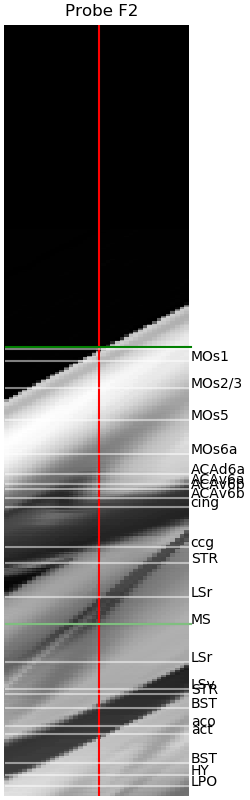

In [72]:
## Plot CCF with border labels ##
fig, ax = plt.subplots(figsize=(2.5,8), constrained_layout=True)

ax.imshow(intensity_values, cmap='gray', aspect='auto')
ax.plot([20,20],[0,j],'-r')
ax.plot([0,40],[surface_ind,surface_ind],'g')
ax.plot([0,40],[tip_ind,tip_ind],'g')
ax.set_axis_off()
ax.set_title(probe)

borders = np.where(np.abs(np.diff(structure_ids)) > 0)[0]
jumps = np.concatenate((np.array([5]),np.diff(borders)))
borders = borders[jumps > 3]

ax.imshow(intensity_values, cmap='gray', aspect='auto')
for border in borders[::1]:
    ax.plot([0,40],[border,border],'-',color='white',alpha=0.5)
    try:
        plt.text(40,border,structure_tree[structure_tree['id'] == structure_ids[border]]['acronym'].iloc[0])
    except IndexError:
        pass
plt.axis('off')

## Save image ##
ccfimage_file = os.path.join(histology_loc, 'CCF_image_{}.png'.format(probe))
# fig.savefig(ccfimage_file, dpi=300)

## Step 3: make physiology plots

Enter locations for both experiment days, then loop through experiments and probes.

In [4]:
histology_loc = r"T:\zap-n-zip\Ephaptic coupling\mouse569065\histology"
data_location = {
    '1': r'T:\zap-n-zip\Ephaptic coupling\mouse569065\pilot1_screwref_2021-05-21_13-12-08',
    '2': None
}
## Can say: None if the dataset doesn't include a 2nd recording

For each experiment, locate probe folders and create the physiology plot.

Found 2 probes for experiment 1, processing...
 ...probeB


<IPython.core.display.Javascript object>


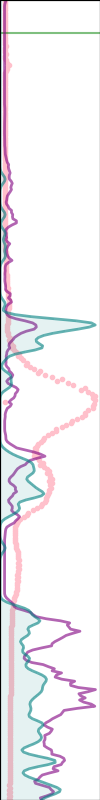

 ...probeF


<IPython.core.display.Javascript object>


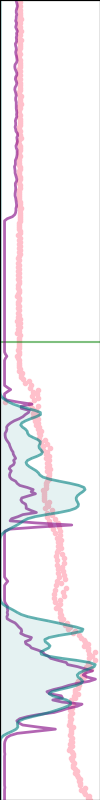

No data location set for experiment 2, not processing.


In [5]:
for expnum, dloc in data_location.items():
    if dloc is None:
        print('No data location set for experiment {}, not processing.'.format(expnum))
        continue
    all_probe_folders = glob(dloc + '/**/*_sorted', recursive=True)
    print('Found {:d} probes for experiment {}, processing...'.format(len(all_probe_folders), expnum))
    
    ## Loop through probes to extract ephys markers ##
    for probe_folder in all_probe_folders:
        probe_name = probe_folder[probe_folder.find('probe'):probe_folder.find('probe')+6]
        print(' ...{}'.format(probe_name))
        phys_output_file = os.path.join(histology_loc, 'physiology_{}_exp{}.png'.format(probe_name, expnum))
        
        ### Get surface ch estimate from probe_info.json ###
        probe_info_location = probe_folder + '/probe_info.json'
        with open(probe_info_location) as data_file:
            data = json.load(data_file)
        surface_ch = int(data['surface_channel'])
        
        ### LFP power ###
        LFP_cont_location = probe_folder + '/continuous/Neuropix-PXI-100.1/continuous.dat'
        raw_data = np.memmap(LFP_cont_location, dtype='int16')
        data = np.reshape(raw_data, (int(raw_data.size / 384), 384))
        
        ## Get power in 10 s window, beginning 60 s after recording start ##
        start_index = int(2500 * 60) # start 60 s into rec
        end_index = start_index + 25000 # look at next 10 s
        
        ## Design Butterworth filter: 1-1000 Hz ##
        b,a = butter(3,[1/(2500/2),1000/(2500/2)],btype='band')

        ## Convert the data to voltage ##
        D = data[start_index:end_index,:] * 0.195

        ## Apply the bandpass filter ##
        for i in range(D.shape[1]):
            D[:,i] = filtfilt(b,a,D[:,i])

        ## Subtract the median of top 14 chs ##
        M = np.median(D[:,370:]) 
        for i in range(D.shape[1]):
            D[:,i] = D[:,i] - M

        ## Get the power across the chs ##
        nfft = 2048
        power = np.zeros((int(nfft/2+1), 384))
        for channel in range(D.shape[1]):
            sample_frequencies, Pxx_den = welch(D[:,channel], fs=2500, nfft=nfft)
            power[:,channel] = Pxx_den
        in_range = (sample_frequencies > 0) * (sample_frequencies < 10)
        
        
        ### Multi-unit firing rate ###
        spthresh = 50
        AP_cont_location = probe_folder + '/continuous/Neuropix-PXI-100.0/continuous.dat'
        raw_apdata = np.memmap(AP_cont_location, dtype='int16')
        apdata = np.reshape(raw_apdata, (int(raw_apdata.size / 384), 384))
        ## Choose the time window to analyze: 60 s after beginning, for 3 s ##
        start_index = int(30000 * 60) 
        end_index = start_index + (30000 * 3)
        ## Bandpass filter: 0.5-10 kHz
        b, a = butter(3, [500/(30000/2),10000/(30000/2)], btype='band')
        ## Count threshold crossings ##
        thresh_crossings = np.zeros((384), dtype=int)
        for chi in range(384):
            chdata = apdata[start_index:end_index, chi] * 0.195
            chdata = filtfilt(b, a, chdata)
            spikes = find_peaks(-chdata, height=spthresh)[0]
            thresh_crossings[chi] = len(spikes)
        ## Smooth the metric a little ##
        spcount = gaussian_filter1d(thresh_crossings, 0.8)
        
        
        ### Unit density ###
        cluster_group = pd.read_csv(probe_folder + '/continuous/Neuropix-PXI-100.0/cluster_group.tsv', sep='\t')
        cluster_metrics = pd.read_csv(probe_folder + '/continuous/Neuropix-PXI-100.0/metrics.csv')
        spike_clusters = np.load(probe_folder + '/continuous/Neuropix-PXI-100.0/spike_clusters.npy')
        
        ## Select good units ##
        isi_viol_thresh=0.5
        amp_cutoff_thresh=0.1
        if np.array_equal(cluster_group['cluster_id'].values.astype('int'), cluster_metrics['cluster_id'].values.astype('int')):
            unit_metrics = pd.merge(
                cluster_group.rename(columns={'group':'label'}),
                cluster_metrics.drop(cluster_metrics.columns[0], axis=1),
                on='cluster_id'
            )
        else:
            print('  IDs from cluster_group DO NOT match cluster_metrics, not creating physiology plot .png.')
            continue
        selected_metrics = unit_metrics[(
            (unit_metrics['label'] == 'good') &
            (unit_metrics['isi_viol'] < isi_viol_thresh) &
            (unit_metrics['amplitude_cutoff'] < amp_cutoff_thresh)
        )]
        units = selected_metrics.cluster_id.values
        unit_channels = selected_metrics.peak_channel.values
        
        ## Get histogram of units per channel ##
        unit_histogram = np.zeros((384), dtype='float')
        total_units = 0
        for unit_idx, unit in enumerate(units):
            channel = unit_channels[unit_idx]
            unit_histogram[channel] += 1 

            total_units += 1
        GF = gaussian_filter1d(unit_histogram*500, 2)
        
        
        ### Create plot and save ###
        fig = plt.figure(frameon=False)
        plt.clf()
        fig.set_size_inches(1,8)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        ## LFP mean power ##
        ax.plot(np.mean(power[in_range,:],0), np.arange(384), '.', color='pink')
        ax.axhline(surface_ch, color='g', alpha=0.5)
        ## Multi-unit spike count ##
        muax = ax.twiny()
        muax.plot(spcount, np.arange(384), linewidth=2.0, alpha=0.6, color='purple')
        ## Unit histogram ##
        uax = ax.twiny()
        uax.barh(np.arange(384), GF, height=1.0, alpha=0.1, color='teal')
        uax.plot(GF, np.arange(384), linewidth=2.0, alpha=0.6, color='teal')
        plt.ylim([0, 384])
        # plt.xlim([-5, 2000])
        fig.savefig(phys_output_file, dpi=300)

### Test on one probe

In [3]:
probe_folder = r"T:\zap-n-zip\EEG_exp\mouse586468\estim_vis_2021-08-19_11-36-53\experiment1\probeB_sorted"
probe_name = probe_folder[probe_folder.find('probe'):probe_folder.find('probe')+6]
print(probe_name)
# phys_output_file = os.path.join(TC_loc, 'physiology_' + probe_name + '.png')
# print(phys_output_file)

probeB


#### LFP power

Load and reshape LFP data

In [5]:
LFP_cont_location = probe_folder + '/continuous/Neuropix-PXI-100.1/continuous.dat'
raw_data = np.memmap(LFP_cont_location, dtype='int16')
data = np.reshape(raw_data, (int(raw_data.size / 384), 384))
print(data.shape)

(21461613, 384)


Get the power of different chs

In [6]:
## Choose the time window to analyze: 60 s after beginning, for 10 s ##
start_index = int(2500 * 60) 
end_index = start_index + 25000

## Design Butterworth filter: 1-1000 Hz ##
b,a = butter(3, [1/(2500/2),1000/(2500/2)], btype='band')

## Convert the data to voltage ##
D = data[start_index:end_index,:] * 0.195

## Apply the bandpass filter ##
for i in range(D.shape[1]):
    D[:,i] = filtfilt(b,a,D[:,i])
    
## Subtract the median of top chs ##
M = np.median(D[:,370:]) 
for i in range(D.shape[1]):
    D[:,i] = D[:,i] - M

## Get the power across the chs ##
# channels = np.arange(D.shape[1])
nfft = 2048
power = np.zeros((int(nfft/2+1), 384))
for channel in range(D.shape[1]):
    sample_frequencies, Pxx_den = welch(D[:,channel], fs=2500, nfft=nfft)
    power[:,channel] = Pxx_den
in_range = (sample_frequencies >= 0) * (sample_frequencies < 10)

## This appears to get the STD of the voltage for each ch...but it's not used in the OPT script ##
# S = np.std(D,0)
# S[S < 10] = np.nan
# S[S > 350] = np.nan

In [24]:
low_range = (sample_frequencies >= 0) * (sample_frequencies < 5)
gamma_range = (sample_frequencies >= 0) * (sample_frequencies < 20)
mua_range = sample_frequencies > 300

Plot the mean power in the specified range: 0-10 Hz

Plot raw LFP for 1 s

<IPython.core.display.Javascript object>


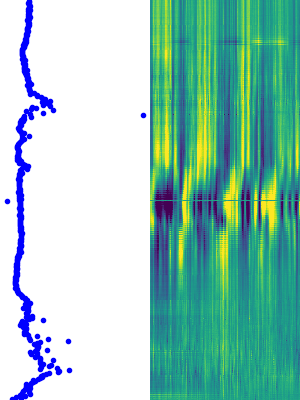

In [10]:
fig = plt.figure(frameon=False)
plt.clf()
fig.set_size_inches(3,4) # (1,8)

ax = plt.Axes(fig, [0., 0., 0.5, 1.])
ax.set_axis_off()
fig.add_axes(ax)
# ax.plot(np.mean(power[in_range,:],0), np.arange(384), '.', color='pink')
ax.plot(np.sum(power[mua_range,:],0), np.arange(384), '.', color='b')
ax.set_ylim([0,384])

lax = plt.Axes(fig, [0.5, 0., 1., 1.])
fig.add_axes(lax)
lax.imshow(D[0:2500,:].T, origin='lower', interpolation='none', aspect='auto', vmin=-400, vmax=300)
lax.set_axis_off()

### Unit density

In [13]:
cluster_group = pd.read_csv(probe_folder + '/continuous/Neuropix-PXI-100.0/cluster_group.tsv', sep='\t')
cluster_metrics = pd.read_csv(probe_folder + '/continuous/Neuropix-PXI-100.0/metrics.csv')
spike_clusters = np.load(probe_folder + '/continuous/Neuropix-PXI-100.0/spike_clusters.npy')

isi_viol_thresh=0.5
amp_cutoff_thresh=0.1

In [15]:
if np.array_equal(cluster_group['cluster_id'].values.astype('int'), cluster_metrics['cluster_id'].values.astype('int')):
    unit_metrics = pd.merge(
        cluster_group.rename(columns={'group':'label'}),
#         cluster_metrics.drop(cluster_metrics.columns[0], axis=1),
        cluster_metrics,
        on='cluster_id'
    )
else:
    print('IDs from cluster_group DO NOT match cluster_metrics.')

In [16]:
selected_metrics = unit_metrics[(
    (unit_metrics['label'] == 'good') &
    (unit_metrics['isi_viol'] < isi_viol_thresh) &
    (unit_metrics['amplitude_cutoff'] < amp_cutoff_thresh)
)]

units = selected_metrics.cluster_id.values
unit_channels = selected_metrics.peak_channel.values
unit_FR = selected_metrics.firing_rate.values
unit_spikeamp = selected_metrics.amplitude.values

In [17]:
unit_histogram = np.zeros((384), dtype='float')
total_units = 0    

for unit_idx, unit in enumerate(units):
    channel = unit_channels[unit_idx]
    unit_histogram[channel] += 1 
    total_units += 1
    
print(total_units)
GF = gaussian_filter1d(unit_histogram*500,2.5)

325


In [18]:
avg_FR = np.zeros((384), dtype=float)
avg_spikeamp = np.zeros((384), dtype=float)

for chi in range(384):
    chmask = np.nonzero(unit_channels == chi)[0]
    if len(chmask) > 0:
        avg_FR[chi] = np.mean(unit_FR[chmask])
        avg_spikeamp[chi] = np.mean(unit_spikeamp[chmask])

### Multi-unit firing rate

In [19]:
AP_cont_location = probe_folder + '/continuous/Neuropix-PXI-100.0/continuous.dat'
raw_apdata = np.memmap(AP_cont_location, dtype='int16')
apdata = np.reshape(raw_apdata, (int(raw_apdata.size / 384), 384))
print(apdata.shape)

(257539356, 384)


In [20]:
spthresh = 50

## Choose the time window to analyze: 60 s after beginning, for 3 s ##
start_index = int(30000 * 60) 
end_index = start_index + (30000 * 3)
b, a = butter(3, [500/(30000/2),10000/(30000/2)], btype='band')

thresh_crossings = np.zeros((384), dtype=int)
for chi in range(384):
    chdata = apdata[start_index:end_index, chi] * 0.195
    chdata = filtfilt(b, a, chdata)
    spikes = find_peaks(-chdata, height=spthresh)[0]
    thresh_crossings[chi] = len(spikes)
    
spcount = gaussian_filter1d(thresh_crossings, 0.8)

### Plot everything together

<IPython.core.display.Javascript object>


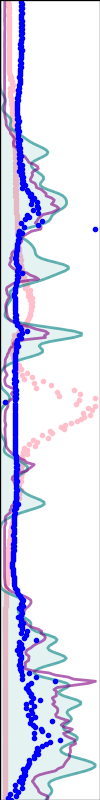

(0, 384)

In [25]:
fig = plt.figure(frameon=False)
plt.clf()
fig.set_size_inches(1,8) # (1,8)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
## LFP mean power ##
ax.plot(np.mean(power[in_range,:],0), np.arange(384), '.', color='pink')
# ax.axhline(368, color='g', alpha=0.6)
## Unit histogram ##
uax = ax.twiny()
uax.barh(np.arange(384), GF, height=1.0, alpha=0.1, color='teal')
uax.plot(GF, np.arange(384), linewidth=2.0, alpha=0.6, color='teal')
## Average firing rate on channel ##
# frax = ax.twiny()
# frax.plot(avg_FR, np.arange(384), linewidth=2.0, alpha=0.6, color='orange')
## Multi-unit spikes in 3 seconds ##
muax = ax.twiny()
muax.plot(spcount, np.arange(384), linewidth=2.0, alpha=0.6, color='purple')
# muax.plot(thresh_crossings, np.arange(384), linewidth=1.5, alpha=0.6, color='blue')
hfax = ax.twiny()
hfax.plot(np.sum(power[mua_range,:],0), np.arange(384), '.', color='b')

plt.ylim([0, 384])
# plt.xlim([-5, 2000])
# fig.savefig(phys_output_file, dpi=300)

## Step 4: use refinement app

Test file name

Test loading the csv and finding borders

## Step 5: extract surface/tip coordinates and structures for stim electrode

In [3]:
structure_tree = pd.read_csv(
    '//allen/programs/braintv/workgroups/tiny-blue-dot/zap-n-zip/TC_CCF_template_files/structure_tree_safe_2017.csv'
)

In [26]:
data_location = {
    1: r'T:\zap-n-zip\Ephaptic coupling\mouse569065\pilot1_screwref_2021-05-21_13-12-08',
    2: None # None
}
stim_elec_location = 'A' # Enter the probe letter location of the stim electrode

for expi, dataloci in data_location.items():
    if dataloci:
        print('Experiment {:d}: {}'.format(expi, os.path.basename(dataloci)))
        histology_dir = os.path.join(os.path.dirname(dataloci), 'histology')
        
        probe_annot_df = pd.read_csv(os.path.join(histology_dir, 'probe_annotations.csv'))
        init_coords_df = pd.read_csv(os.path.join(histology_dir, 'initial_ccf_coordinates_exp{:d}.csv'.format(expi)))
        
        stimdf = init_coords_df[init_coords_df['probe'] == 'probe' + stim_elec_location].reset_index(drop=True)
        stim_tip_DV = np.sort(
            probe_annot_df['DV'][probe_annot_df['probe_name'] == 'Probe ' + stim_elec_location + str(expi)].values)[-1]
        
        surface_ind = np.nonzero(stimdf['structure_id'].values)[0][0]
        surface_region = structure_tree[structure_tree.id == stimdf['structure_id'].iloc[surface_ind]]['acronym'].iloc[0]
        surface_coords = np.array([
            stimdf['A/P'].iloc[surface_ind], stimdf['D/V'].iloc[surface_ind], stimdf['M/L'].iloc[surface_ind]])
        print(' Stim electrode surface: {}, [{:d},{:d},{:d}] (A/P,D/V,M/L)'.format(
            surface_region, surface_coords[0], surface_coords[1], surface_coords[2]
        ))
        
        tip_ind = stimdf.index[stimdf['D/V'] == stim_tip_DV].tolist()[0]
        tip_region = structure_tree[structure_tree.id == stimdf['structure_id'].iloc[tip_ind]]['acronym'].iloc[0]
        tip_coords = np.array([
            stimdf['A/P'].iloc[tip_ind], stimdf['D/V'].iloc[tip_ind], stimdf['M/L'].iloc[tip_ind]])
        print(' Stim electrode tip: {}, [{:d},{:d},{:d}] (A/P,D/V,M/L)'.format(
            tip_region, tip_coords[0], tip_coords[1], tip_coords[2]
        ))
        
        len_stim_elec = np.linalg.norm(surface_coords - tip_coords) * 0.025 # CCF: 25 um resolution
        print(' Length of stim electrode in brain: {:.2f} mm'.format(len_stim_elec))
        
        ## Save stim_elec_location.json ##
        stim_loc = {
            'surface': {'area': surface_region, 'ccf_coords': surface_coords.tolist()},
            'tip': {'area': tip_region, 'ccf_coords': tip_coords.tolist()},
        }
        filename = os.path.join(dataloci, 'experiment1', 'recording1', 'stim_elec_location.json')
        with open(filename, 'w') as outfile:
            json.dump(stim_loc, outfile, indent = 4, separators = (',', ': '))
        print(' Saved {}.'.format(filename))
        
    print('')

Experiment 1: pilot1_screwref_2021-05-21_13-12-08
 Stim electrode surface: RSPagl1, [277,13,177] (A/P, D/V, M/L)
 Stim electrode tip: RSPagl6a, [282,42,180] (A/P, D/V, M/L)
 Length of stim electrode in brain: 0.74 mm
 Saved T:\zap-n-zip\Ephaptic coupling\mouse569065\pilot1_screwref_2021-05-21_13-12-08\experiment1\recording1\stim_elec_location.json.


Testing

Find surface of brain

## Step 6: take refinement output .csv and add values to our files

In [3]:
midline_ind = 228

In [7]:
structure_tree = pd.read_csv(
    '//allen/programs/braintv/workgroups/tiny-blue-dot/zap-n-zip/TC_CCF_template_files/structure_tree_safe_2017.csv'
)

In [4]:
final_coordinates = {
    r'T:\zap-n-zip\Ephaptic coupling\mouse569065\histology\final_ccf_coordinates_exp1.csv': r'T:\zap-n-zip\Ephaptic coupling\mouse569065\pilot1_screwref_2021-05-21_13-12-08'
} # enter final coordinates .csv and matching data location, experiment folder

In [5]:
for final_csv, dloc in final_coordinates.items():
    ## Find probes in experiment folder ##
    all_probe_folders = glob(dloc + '/**/*_sorted', recursive=True)
    probe_list = [x[x.find('_sorted')-6:x.find('_sorted')] for x in all_probe_folders]
    print('Found {:d} probes for this experiment, processing...'.format(len(all_probe_folders)))
    finaldf = pd.read_csv(final_csv)

Found 2 probes for this experiment, processing...


In [62]:
probe_ind = 1

probedf = finaldf[finaldf.probe == probe_list[probe_ind]].reset_index(drop=True)
# probedf.head()

assigned_regions = probedf['structure_id'].values
borders = np.where(np.diff(assigned_regions) != 0)[0]
## Get the 3d direction of the probe ##
probe_axis = np.vstack((probedf['A/P'].values, probedf['D/V'].values, probedf['M/L'].values)).T
axmean = probe_axis.mean(axis=0)
uu,dd,vv = np.linalg.svd(probe_axis - axmean)

allch_coords = np.zeros((384,3), dtype=int)
all_structids = np.zeros((384,), dtype=int)
allch_areas = []
cha = 384
for bordi in borders:
    d_ind = probedf.index[probedf['channels'] == cha].tolist()[0]
    chb = probedf['channels'].loc[bordi]
    if chb < 0:
        chb = 0
        bordi = probedf.index[probedf['channels'] == chb].tolist()[0]
    find_chs = np.arange(chb, cha)
    ab_dist = np.linalg.norm(probe_axis[d_ind,:] - probe_axis[bordi,:])
    chdists = np.flip(np.linspace(0, ab_dist, len(find_chs)))
    allch_coords[find_chs,:] = np.round(vv[0] * chdists[:,np.newaxis] + probe_axis[d_ind,:]).astype(int)
    region_id = probedf['structure_id'].loc[bordi]
    all_structids[find_chs] = region_id
    if region_id == 0:
        region_name = "null"
    else:
        region_name = structure_tree[structure_tree.id == region_id]['acronym'].iloc[0]
    allch_areas.extend([region_name] * len(find_chs))
    if chb == 0:
        break
    cha = find_chs[0]
    
is_ipsi = allch_coords[:,2] < midline_ind
allch_areas = list(np.flip(allch_areas)) # flip order because list is backwards

## Update probe_info.json file with ch locations ##
probe_info_location = os.path.join(all_probe_folders[probe_ind], 'probe_info.json')
with open(probe_info_location) as read_data_file:
    probe_data = json.load(read_data_file)

probe_data["area_ch"] = allch_areas
probe_data["ccf_coord_ch"] = allch_coords.tolist()
probe_data["is_ipsi_ch"] = is_ipsi.tolist()
probe_data["ccf_resolution"] = 25

with open(probe_info_location, 'w') as outfile:
    json.dump(probe_data, outfile, indent = 4, separators = (',', ': '))
    
## Update metrics.csv file with unit locations ##
unit_info_location = os.path.join(all_probe_folders[probe_ind], r'continuous\Neuropix-PXI-100.0\metrics.csv')
unit_metrics = pd.read_csv(unit_info_location)
if 'Unnamed: 0' in unit_metrics.columns:
    unit_metrics.drop('Unnamed: 0', axis=1, inplace=True)

unit_area = []
unit_coords = []
unit_ipsi = []
for ind, row in unit_metrics.iterrows():
    unit_area.append(allch_areas[row['peak_channel']])
    unit_coords.append(list(allch_coords[row['peak_channel'],:]))
    unit_ipsi.append(is_ipsi[row['peak_channel']])
unit_metrics['area'] = unit_area
unit_metrics['ccf_coord'] = unit_coords
unit_metrics['is_ipsi'] = unit_ipsi

unit_metrics.to_csv(unit_info_location, index=False)

Testing

In [19]:
probedf[405:415]

,probe,structure_id,A/P,D/V,M/L,channels
405,probeB,362,281,154,195,8
406,probeB,362,281,155,195,6
407,probeB,362,281,156,196,5
408,probeB,362,281,156,196,3
409,probeB,362,281,157,196,2
410,probeB,362,281,158,196,0
411,probeB,362,281,158,196,-2
412,probeB,362,281,159,196,-3
413,probeB,362,281,160,196,-5
414,probeB,362,282,160,196,-6


In [17]:
xs = np.array([269,13,180])
ys = np.array([281,158,196])

chx = 366
chy = 0

mmpix = 0.025 # mm, we are using CCF with 25 um resolution
NPX_dist_per_row = 0.02
NPX_chs_per_row = 2

xydist = np.linalg.norm(xs - ys) * mmpix
print('Distance between two CCF points: {:.2f} mm'.format(xydist)) # this is in mm now

numchs = int(xydist * NPX_chs_per_row / NPX_dist_per_row)
print('In that distance we would expect {:d} chs, but refinement says {:d}.'.format(numchs, chx-chy))

Distance between two CCF points: 3.66 mm
In that distance we would expect 365 chs, but refinement says 366.


In [29]:
structure_tree[structure_tree.id == 575]['acronym'].iloc[0]

'CL'

In [54]:
area_estimate = probedf['structure_id'].values
borders = np.where(np.diff(area_estimate) != 0)[0]

cha = 384
## Get the 3d direction of the probe ##
probe_axis = np.vstack((probedf['A/P'].values, probedf['D/V'].values, probedf['M/L'].values)).T
axmean = probe_axis.mean(axis=0)
uu,dd,vv = np.linalg.svd(probe_axis - axmean)

allch_coords = np.zeros((384,3), dtype=int)
all_structids = np.zeros((384,), dtype=int)
allch_areas = []
for bordi in borders:
#     print('ch{:d} - num chs processed = {:d}'.format(cha, len(allch_areas)))
    d_ind = probedf.index[probedf['channels'] == cha].tolist()[0]
    chb = probedf['channels'].loc[bordi]
    if chb < 0:
        chb = 0
        bordi = probedf.index[probedf['channels'] == chb].tolist()[0]
#     print(chb)
    find_chs = np.arange(chb, cha)
    ab_dist = np.linalg.norm(probe_axis[d_ind,:] - probe_axis[bordi,:])
    chdists = np.flip(np.linspace(0, ab_dist, len(find_chs)))
    allch_coords[find_chs,:] = np.round(vv[0] * chdists[:,np.newaxis] + probe_axis[d_ind,:]).astype(int)
    region_id = probedf['structure_id'].loc[bordi]
    all_structids[find_chs] = region_id
    if region_id == 0:
        region_name = "null"
    else:
        region_name = structure_tree[structure_tree.id == region_id]['acronym'].iloc[0]
    allch_areas.extend([region_name] * len(find_chs))
    if chb == 0:
        break
    cha = find_chs[0]
    
is_ipsi = allch_coords[:,2] < midline_ind
allch_areas = list(np.flip(allch_areas)) # flip order because list is backwards

Add info to the probe_info.json

In [126]:
probe_info_location = os.path.join(all_probe_folders[chind], 'probe_info.json')
with open(probe_info_location) as data_file:
    probe_data = json.load(data_file)

probe_data["area_ch"] = allch_areas
probe_data["ccf_coord_ch"] = allch_coords.tolist()
probe_data["is_ipsi_ch"] = is_ipsi.tolist()
probe_data["ccf_resolution"] = 25

Add info to the unit metrics.csv file

In [47]:
unit_info_location = os.path.join(all_probe_folders[probe_ind], r'continuous\Neuropix-PXI-100.0\metrics.csv')
unit_metrics = pd.read_csv(unit_info_location)
if 'Unnamed: 0' in unit_metrics.columns:
    unit_metrics.drop('Unnamed: 0', axis=1, inplace=True)
unit_metrics.head()

,cluster_id,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,isolation_distance,l_ratio,d_prime,nn_hit_rate,nn_miss_rate,...,snr,duration,halfwidth,PT_ratio,repolarization_slope,recovery_slope,amplitude,spread,velocity_above,velocity_below
0,0,1.866726,0.99,0.133649,0.088845,45.191380,0.000857,6.066841,0.949153,0.000540,...,1.672823,0.508208,0.288442,0.549472,0.262350,-0.036486,71.478225,30.0,0.343384,NaN
1,1,8.688334,0.99,0.324931,0.011129,45.157376,0.007191,4.509779,0.907333,0.005429,...,2.718067,0.494472,0.206030,0.489647,0.431514,-0.072560,144.811680,40.0,0.618090,NaN
2,2,9.209791,0.99,0.186684,0.001150,41.139070,0.011562,3.326604,0.898000,0.005404,...,2.835536,0.563149,0.247236,0.566661,0.423804,-0.082909,161.445570,50.0,0.274707,NaN
3,3,5.441547,0.99,1.667208,0.366350,32.671257,0.013575,2.732577,0.811175,0.007493,...,1.552734,0.576884,0.260972,0.611418,0.283345,-0.051793,106.779075,50.0,0.549414,NaN
4,4,8.557866,0.99,0.004239,0.000828,92.687896,0.000105,6.581686,0.992000,0.000325,...,5.072333,0.370854,0.137353,0.504198,1.230177,-0.243535,328.437720,30.0,0.000000,NaN


In [58]:
unit_area = []
unit_coords = []
unit_ipsi = []
for ind, row in unit_metrics.iterrows():
    unit_area.append(allch_areas[row['peak_channel']])
    unit_coords.append(list(allch_coords[row['peak_channel'],:]))
    unit_ipsi.append(is_ipsi[row['peak_channel']])
unit_metrics['area'] = unit_area
unit_metrics['ccf_coord'] = unit_coords
unit_metrics['is_ipsi'] = unit_ipsi
unit_metrics.head()

,cluster_id,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,isolation_distance,l_ratio,d_prime,nn_hit_rate,nn_miss_rate,...,PT_ratio,repolarization_slope,recovery_slope,amplitude,spread,velocity_above,velocity_below,area,ccf_coord,is_ipsi
0,0,1.866726,0.99,0.133649,0.088845,45.191380,0.000857,6.066841,0.949153,0.000540,...,0.549472,0.262350,-0.036486,71.478225,30.0,0.343384,NaN,MD,"[281, 158, 195]",True
1,1,8.688334,0.99,0.324931,0.011129,45.157376,0.007191,4.509779,0.907333,0.005429,...,0.489647,0.431514,-0.072560,144.811680,40.0,0.618090,NaN,MD,"[281, 158, 195]",True
2,2,9.209791,0.99,0.186684,0.001150,41.139070,0.011562,3.326604,0.898000,0.005404,...,0.566661,0.423804,-0.082909,161.445570,50.0,0.274707,NaN,MD,"[281, 158, 195]",True
3,3,5.441547,0.99,1.667208,0.366350,32.671257,0.013575,2.732577,0.811175,0.007493,...,0.611418,0.283345,-0.051793,106.779075,50.0,0.549414,NaN,MD,"[281, 158, 195]",True
4,4,8.557866,0.99,0.004239,0.000828,92.687896,0.000105,6.581686,0.992000,0.000325,...,0.504198,1.230177,-0.243535,328.437720,30.0,0.000000,NaN,MD,"[281, 157, 195]",True


In [61]:
## Overwrite metrics.csv file with area assignments ##
# test_location = os.path.join(all_probe_folders[probe_ind], r'continuous\Neuropix-PXI-100.0\metrics_test.csv')
unit_metrics.to_csv(unit_info_location, index=False)

# OLD code practicing with SharpTrack outputs

### Practice loading processing.mat file

In [5]:
hist_file = r"C:\Users\lesliec\OneDrive - Allen Institute\ZZ_histology\Processed\546655\processed\probe_pointsSections546655.mat"
probe_points_info = sio.loadmat(hist_file)
probe_points = probe_points_info['pointList'][0,0][0]

What is in the probe_points.mat file? When we load the file with sio.loadmat(), it loads as a dictionary. The important information is in the 'pointList' key. Inside probe_points_info['pointList'][0,0][0] is an nx3 array, where n is the number of probes selected in the sharp track gui (by Jackie). For each probe selected, the array contains the following info: the CCF coordinates of the points clicked along the image [n, 0], the slide number associated with the points clicked [n, 1], and the processed image file name associated with each point clicked [n, 2].

In [6]:
probe_points.shape

(3, 3)

In [7]:
probe_points[0,0]

array([[469, 170, 324],
       [453, 173, 336],
       [449, 201, 336],
       [445, 230, 336],
       [446, 215, 357],
       [435, 246, 357],
       [434, 274, 357],
       [430, 267, 369],
       [420, 295, 369],
       [418, 326, 369],
       [437, 296, 384],
       [426, 322, 384],
       [416, 351, 384],
       [408, 380, 384],
       [402, 402, 384],
       [408, 407, 396],
       [398, 431, 396],
       [388, 453, 396],
       [381, 484, 396],
       [377, 500, 408],
       [372, 524, 408],
       [364, 546, 408]], dtype=uint16)

In [8]:
probe_points[0,0].shape

(22, 3)

### Find surface and tip of each identified probe, by making a best-fit-line between the clicked points.

Finding clues here:
<br>https://stackoverflow.com/questions/2298390/fitting-a-line-in-3d

<IPython.core.display.Javascript object>


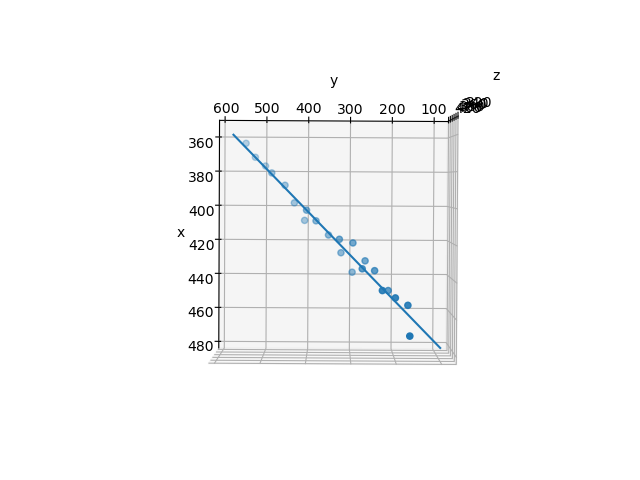

In [9]:
probei = 0

xs = probe_points[probei, 0][:, 0]
ys = probe_points[probei, 0][:, 1]
zs = probe_points[probei, 0][:, 2]

## make a best fit line ##
datamean = np.mean(probe_points[probei, 0], axis=0)
uu, dd, vv = np.linalg.svd(probe_points[probei, 0] - datamean)
linepts = vv[0] * np.array([[-1, -1, -1], [1, 1, 1]]) * 250
linepts += datamean
lx = linepts[:, 0]
ly = linepts[:, 1]
lz = linepts[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot(lx, ly, lz)

In [14]:
print(vv[0] * np.array([2,2,2]) + datamean)

[416.6244799  342.49490816 374.85106952]


In [22]:
print(np.linalg.norm(probe_points[probei, 0][-1, :] - probe_points[probei, 0][0, :]))

654.3213425374416


In [23]:
print(probe_points[probei, 0][-1, :])
print(probe_points[probei, 0][0, :])

[364 546 408]
[469 170 324]


In [21]:
print(probe_points[probei, 0][-1, :])

[364 546 408]


<IPython.core.display.Javascript object>


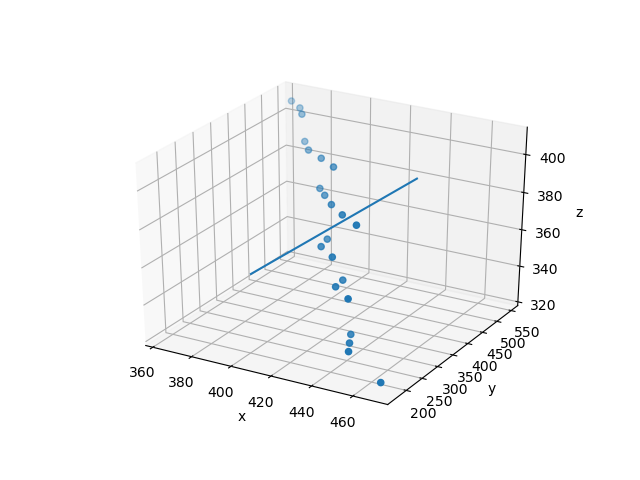

In [12]:
probei = 0

xs = probe_points[probei, 0][:, 0]
ys = probe_points[probei, 0][:, 1]
zs = probe_points[probei, 0][:, 2]

## make a best fit line ##
datamean = np.mean(probe_points[probei, 0], axis=0)
uu, dd, vv = np.linalg.svd(probe_points[probei, 0] - datamean)
linepts = vv[0] * (np.array([probe_points[probei, 0][-1, :], probe_points[probei, 0][0, :]]) - datamean)
linepts += datamean
lx = linepts[:, 0]
ly = linepts[:, 1]
lz = linepts[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot(lx, ly, lz)